In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from einops import rearrange, repeat,reduce
from einops.layers.torch import Rearrange
from torch import linalg as LA

In [3]:
import torch
import sys, os
import json
import torch.nn as nn  
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.optim as optim

# from torch.utils.tensorboard import SummaryWriter
import prettytable
import time, random,timeit
sys.setrecursionlimit(15000)
from thop.profile import profile

from PIL import Image
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchsummary import summary
from tqdm.notebook import tqdm
import seaborn as sns

from utils import ImageShow,draw_size_acc,one_hot,setup_seed
from utils import confusion_matrix,metrics_scores,pff

setup_seed(3047)

from model import CapsNet

In [4]:
# Settings.
sys.path.append(os.pardir)
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
img_title = "HAM10000"#"Skin_Cancer"
best_acc = 0.
eval_acc = 0.
best_train = 0.
dict_batch = {}
dict_imgSize = {}


try:
    print(len(train_acc_list))
except NameError:
    train_loss_list = []
    train_acc_list = []
    test_loss_list = []
    test_acc_list = []
    test_auc_list = []
    val_loss_list = []
    val_acc_list = []
#activate ImageShow
show = ImageShow(train_loss_list = train_loss_list,
                 train_acc_list = train_acc_list,
                test_loss_list = test_loss_list,
                test_acc_list = test_acc_list,
                test_auc_list = test_auc_list,
                val_loss_list = val_loss_list,
                val_acc_list = val_acc_list,
                )

In [5]:
# normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                  std=[0.229, 0.224, 0.225])
normalize = transforms.Normalize([0.5, 0.5, 0.5],[0.5, 0.5, 0.5])
# Resize = transforms.Resize((299,299))

def get_data(mode='ALL'):
    global test_dataset,train_loader,val_loader,test_loader
    global train_num,val_num,test_num,n_classes,cla_dict
    # vt = int(trans)
    data_transform = {
        "train": transforms.Compose([#Resize,
                                     transforms.RandomVerticalFlip(),
                                     transforms.ToTensor(),
                                     normalize]),
        "val": transforms.Compose([#Resize,
                                   transforms.ToTensor(),
                                   normalize]),
        "test": transforms.Compose([#Resize,
                                    transforms.ToTensor(),
                                    normalize]),}    
    if mode == 'ALL':
        train_dataset = datasets.ImageFolder(root=train_dir,transform=data_transform["train"])
        val_dataset = datasets.ImageFolder(root=val_dir,transform=data_transform["val"])
        test_dataset = datasets.ImageFolder(root=test_dir,transform=data_transform["test"])

        train_num = len(train_dataset)
        val_num = len(val_dataset)
        test_num = len(test_dataset)

        train_loader = DataLoader(train_dataset,batch_size=BatchSize,
                                                   pin_memory=pin_memory,
                                                   shuffle=True,num_workers=nw)
        val_loader = DataLoader(val_dataset,batch_size=V_size,
                                                   pin_memory=pin_memory,
                                                   shuffle=False,num_workers=nw)
        test_loader = DataLoader(test_dataset,batch_size=T_size,
                                                  pin_memory=pin_memory,
                                                  shuffle=False,num_workers=nw)

        print("using {} images for training, {} images for validation, {} images for testing.".format(train_num,
                                                                                                      val_num,
                                                                                                      test_num))
    else:
        test_dataset = datasets.ImageFolder(root=test_dir,transform=data_transform["test"])
        test_num = len(test_dataset)
        test_loader = DataLoader(test_dataset,batch_size=T_size,
                                                  pin_memory=pin_memory,
                                                  shuffle=False,num_workers=nw)
        print(f"using {test_num} images for testing.")
    
    data_list = test_dataset.class_to_idx
    cla_dict = dict((val, key) for key, val in data_list.items())
    n_classes  = len(data_list)

In [6]:
data_root = os.path.abspath(os.path.join(os.getcwd(),".."))
image_path = os.path.join(data_root, "datasets","HAM10000")#skin2023
assert os.path.exists(image_path), "{} path does not exist.".format(image_path)

BatchSize = 168
V_size = 21
T_size = 21

sub_dirs = "300"
train_doc = f"{sub_dirs}/train"
val_doc = f"{sub_dirs}/val" 
test_doc = f"{sub_dirs}/test" 

train_dir=os.path.join(image_path,train_doc)
val_dir=os.path.join(image_path,val_doc)
test_dir=os.path.join(image_path,test_doc)
pin_memory = True
nw = 6#min([os.cpu_count(), BatchSize if BatchSize > 1 else 0, 6]) 
print(f'Using {nw} dataloader workers every process.')
get_data()
print(f'Using {n_classes} classes.')

Using 6 dataloader workers every process.
using 8181 images for training, 828 images for validation, 1006 images for testing.
Using 7 classes.


In [7]:
n_channels = 3 #RGB

network = CapsNet(conv_inputs=n_channels, 
                     num_classes=n_classes,# category_number
                     init_weights=True,)
network = network.to(device)

In [8]:
learning_rate = 0.123
optimizer = optim.Adam(network.parameters(), lr=learning_rate)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, 5, eta_min=1e-8, last_epoch=-1)

In [9]:
# img_size = 299
# summary(network,(n_channels,300,225))

In [10]:
network.Convolution

Sequential(
  (0): Conv2d(3, 128, kernel_size=(21, 21), stride=(2, 2))
  (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
)

In [11]:
# dsize = (1, 3, 300, 225)
# # mode='DS'
# input_data = torch.randn(dsize).to(device)
# pff(m_name="FixCaps",model=network,inputes=input_data)

In [12]:
def train(epoch):
    network.train()
    global best_train,train_evl_result#,evl_tmp_result
    running_loss,r_pre = 0., 0.
    print_step = len(train_loader)//2
    steps_num = len(train_loader)
    tmp_size = BatchSize
    print(f'\033[1;32m[Train Epoch:[{epoch}]{img_title} ==> Training]\033[0m ...')
    optimizer.zero_grad()
    train_tmp_result = torch.zeros(n_classes,n_classes)
    startT = timeit.default_timer() 
    
    for batch_idx, (data, target) in enumerate(train_loader):        

        batch_idx += 1
        target_indices = target
        target_one_hot = one_hot(target, length=n_classes)
        data, target = Variable(data).to(device), Variable(target_one_hot).to(device)

        output = network(data)
        loss = network.loss(output, target, size_average=True)       
        loss.backward()     
        optimizer.step()
        optimizer.zero_grad()
        
        running_loss += loss.item()
        
        # v_mag = torch.sqrt(torch.sum(output**2, dim=2, keepdim=True)) 
        # v_mag = torch.norm(output,p=2,dim=(2,3), keepdim=True)
        v_mag = LA.norm(output,ord='nuc',dim=(2,3), keepdim=True)#‘fro’ (default)
        pred = v_mag.data.max(1, keepdim=True)[1].cpu().squeeze()
        r_pre += pred.eq(target_indices.view_as(pred)).squeeze().sum()
        tmp_pre = r_pre/(batch_idx*BatchSize)
        
        if batch_idx % print_step == 0 and batch_idx != steps_num:
            print("[{}/{}] Loss{:.5f},ACC:{:.5f}".format(batch_idx,len(train_loader),
                                                         loss,tmp_pre))
        if batch_idx % steps_num == 0 and train_num % tmp_size != 0:
            tmp_size = train_num % tmp_size
                          
        for i in range(tmp_size):
            pred_x = pred.numpy()
            train_tmp_result[target_indices[i]][pred_x[i]] +=1

        if best_train < tmp_pre and tmp_pre >= 90: 
            torch.save(network.state_dict(), iter_path)
        
    epoch_acc = r_pre / train_num
    epoch_loss = running_loss / len(train_loader)  
    train_loss_list.append(epoch_loss)
    train_acc_list.append(epoch_acc) 
    scheduler.step()
    if best_train < epoch_acc:
        best_train = epoch_acc
        train_evl_result = train_tmp_result.clone()
        torch.save(network.state_dict(), last_path)
        torch.save(train_evl_result, f'./tmp/{img_title}/{dirs}/train_evl_result.pth')
    
    endT = timeit.default_timer()
    run_time = endT-startT
    print("Train Epoch:[{}] Running:[{:.2f}s], Loss:{:.5f},Acc:{:.5f},Best_train:{:.5f}".format(epoch,run_time,
                                                                                                 epoch_loss,
                                                                                                 epoch_acc,best_train))

In [13]:
def test(split="test"):
    network.eval()
    global test_acc,eval_acc,best_acc,net_parameters
    global test_evl_result,val_evl_result#,evl_tmp_result
    cor_loss,correct,Auc, Acc= 0, 0, 0, 0
    evl_tmp_result = torch.zeros(n_classes,n_classes)
    
    if split == 'val':
        data_loader = val_loader
        tmp_size = V_size
        data_num = val_num
    else:
        data_loader = test_loader
        tmp_size = T_size
        data_num = test_num
        
    steps_num = len(data_loader)
    print(f'\033[35m{img_title} ==> {split} ...\033[0m')
    
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(data_loader):
            batch_idx +=1
            target_indices = target#torch.Size([batch, 7])  
            target_one_hot = one_hot(target, length=n_classes)            
            data, target = Variable(data).to(device), Variable(target_one_hot).to(device)

            output= network(data)#torch.Size([batch_size, 7, 16, 1])         
            v_mag = LA.norm(output,ord='nuc',dim=(2,3), keepdim=True)#
            pred = v_mag.data.max(1, keepdim=True)[1].cpu()#[9, 2, 1, 1, 6,..., 1, 4, 6, 5, 7,]
            
            if batch_idx % steps_num == 0 and data_num % tmp_size != 0:
                tmp_size = data_num % tmp_size
                          
            for i in range(tmp_size):
                pred_y = pred.numpy()
                evl_tmp_result[target_indices[i]][pred_y[i]] +=1 

        diag_sum = torch.sum(evl_tmp_result.diagonal())
        all_sum = torch.sum(evl_tmp_result) 
        test_acc = 100. * float(torch.div(diag_sum,all_sum)) 
        print(f"{split}_Acc:\033[1;32m{round(float(test_acc),3)}%\033[0m")

        if split == 'val':
            val_acc_list.append(test_acc)
            if test_acc >= best_acc:
                best_acc = test_acc
                val_evl_result = evl_tmp_result.clone()#copy.deepcopy(input)
                torch.save(network.state_dict(), save_PATH)
                torch.save(val_evl_result, f'./tmp/{img_title}/{dirs}/best_evl_result.pth')
            print(f"Best_val:\033[1;32m[{round(float(best_acc),3)}%]\033[0m")
        else:
            test_acc_list.append(test_acc)
            if test_acc >= eval_acc:
                eval_acc = test_acc
                test_evl_result = evl_tmp_result.clone()#copy.deepcopy(input)
                torch.save(network.state_dict(), test_path)
                torch.save(test_evl_result, f'./tmp/{img_title}/{dirs}/{split}_evl_result.pth')
            print(f"Best_eval:\033[1;32m[{round(float(eval_acc),3)}%]\033[0m")  

In [14]:
num_epochs= 128

In [15]:
#create store
try:
    print(f"suf:{suf}")
except NameError:
    suf = time.strftime("%m%d_%H%M%S", time.localtime())
    dirs = suf + f"_{sub_dirs}_{num_epochs}ep_"
    print(f"suf:{suf}")   
if os.path.exists(f'./tmp/{img_title}/{dirs}'):
    print (f'Store: "./tmp/{img_title}/{dirs}"')
else:
    !mkdir -p ./tmp/{img_title}/{dirs}
iter_path = f'./tmp/{img_title}/{dirs}/train_{img_title}_{suf}.pth' #training
save_PATH = f'./tmp/{img_title}/{dirs}/best_{img_title}_{suf}.pth' #validation
last_path = f'./tmp/{img_title}/{dirs}/last_{img_title}_{suf}.pth' #training
test_path = f'./tmp/{img_title}/{dirs}/test_best_{img_title}_{suf}.pth' #testing
print(save_PATH)

suf:0404_195941
./tmp/HAM10000/0404_195941_300_128ep_/best_HAM10000_0404_195941.pth


In [16]:
# network.load_state_dict(torch.load(last_path))
for epoch in range(1, num_epochs + 1): 
    train(epoch)
    test('val')
    
print('Finished Training')

[Train Epoch:[1]HAM10000 ==> Training] ...
[24/49] Loss0.27447,ACC:0.41865
[48/49] Loss0.29301,ACC:0.53708
Train Epoch:[1] Running:[18.97s], Loss:0.40013,Acc:0.53930,Best_train:0.53930
HAM10000 ==> val ...
val_Acc:80.072%
Best_val:[80.072%]
[Train Epoch:[2]HAM10000 ==> Training] ...
[24/49] Loss0.26875,ACC:0.66344
[48/49] Loss0.27090,ACC:0.65377
Train Epoch:[2] Running:[17.08s], Loss:0.25953,Acc:0.65261,Best_train:0.65261
HAM10000 ==> val ...
val_Acc:82.367%
Best_val:[82.367%]
[Train Epoch:[3]HAM10000 ==> Training] ...
[24/49] Loss0.21509,ACC:0.63839
[48/49] Loss0.21304,ACC:0.65141
Train Epoch:[3] Running:[17.18s], Loss:0.23946,Acc:0.65151,Best_train:0.65261
HAM10000 ==> val ...
val_Acc:84.903%
Best_val:[84.903%]
[Train Epoch:[4]HAM10000 ==> Training] ...
[24/49] Loss0.21161,ACC:0.65327
[48/49] Loss0.20804,ACC:0.65997
Train Epoch:[4] Running:[17.20s], Loss:0.22536,Acc:0.65994,Best_train:0.65994
HAM10000 ==> val ...
val_Acc:84.903%
Best_val:[84.903%]
[Train Epoch:[5]HAM10000 ==> Trainin

In [17]:
show.conclusion(opt='val',img_title=img_title)

=================Conclusion====================
Dataset:[HAM10000]
Best_Epoch [103]
[Val] ACC:96.38%.


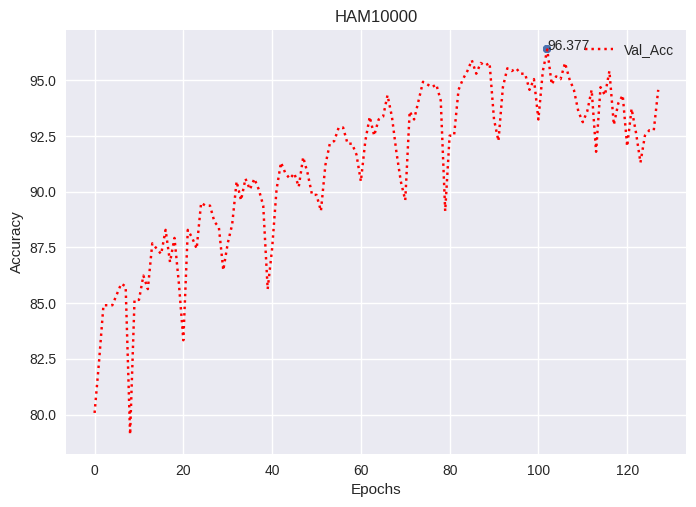

In [18]:
show.val(write=True,custom_path='./tmp',img_title=img_title,suf=dirs)

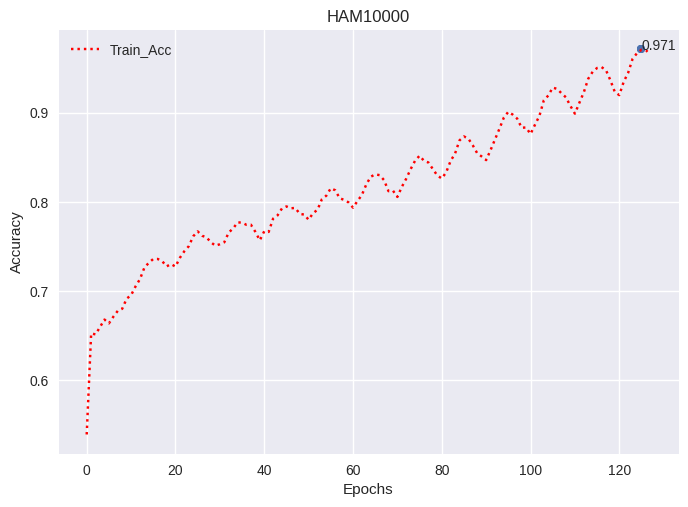

In [19]:
show.train(opt='Acc',write=True,custom_path='./tmp',img_title=img_title,suf=dirs)

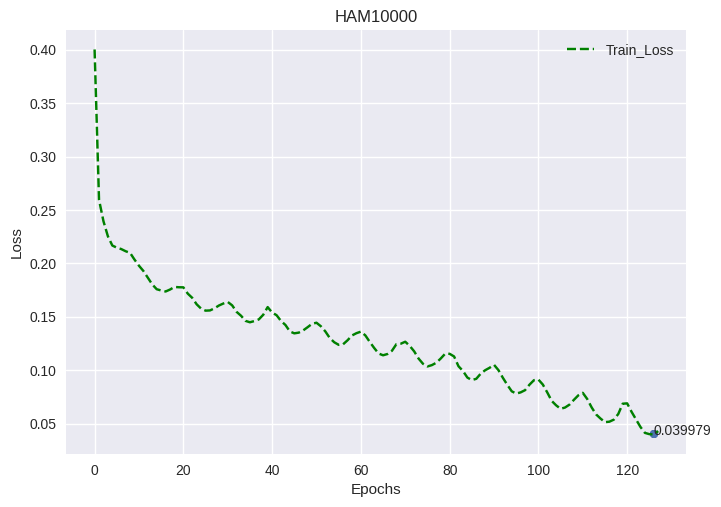

In [20]:
plt.clf()#clear photo
show.train(write=True,custom_path='./tmp',img_title=img_title,suf=dirs)

In [21]:
network.load_state_dict(torch.load(save_PATH))

dict_bat = {}
for k in range(8,49):
    T_size = k

    print(f"T_size:{k}")
    get_data('test')

    # for j in range(3):
    test()

    if dict_bat.get(k) is None or dict_bat[k] < test_acc:
            dict_bat[k] = test_acc

T_size:8
using 1006 images for testing.
HAM10000 ==> test ...
test_Acc:85.388%
Best_eval:[85.388%]
T_size:9
using 1006 images for testing.
HAM10000 ==> test ...
test_Acc:87.177%
Best_eval:[87.177%]
T_size:10
using 1006 images for testing.
HAM10000 ==> test ...
test_Acc:89.662%
Best_eval:[89.662%]
T_size:11
using 1006 images for testing.
HAM10000 ==> test ...
test_Acc:90.457%
Best_eval:[90.457%]
T_size:12
using 1006 images for testing.
HAM10000 ==> test ...
test_Acc:91.849%
Best_eval:[91.849%]
T_size:13
using 1006 images for testing.
HAM10000 ==> test ...
test_Acc:89.662%
Best_eval:[91.849%]
T_size:14
using 1006 images for testing.
HAM10000 ==> test ...
test_Acc:93.241%
Best_eval:[93.241%]
T_size:15
using 1006 images for testing.
HAM10000 ==> test ...
test_Acc:94.93%
Best_eval:[94.93%]
T_size:16
using 1006 images for testing.
HAM10000 ==> test ...
test_Acc:93.837%
Best_eval:[94.93%]
T_size:17
using 1006 images for testing.
HAM10000 ==> test ...
test_Acc:93.042%
Best_eval:[94.93%]
T_size

In [22]:
show.conclusion(img_title=img_title)
print(sorted(dict_bat.items(), key=lambda x: x[1], reverse=True)[0:9])

=================Conclusion====================
Dataset:[HAM10000]
Best_Epoch [23]
[Test] ACC:96.52%.
[(30, 96.52087688446045), (32, 95.62624096870422), (19, 95.5268383026123), (29, 95.5268383026123), (33, 95.32803297042847), (31, 95.22863030433655), (27, 95.12922167778015), (15, 94.93041634559631), (22, 94.93041634559631)]


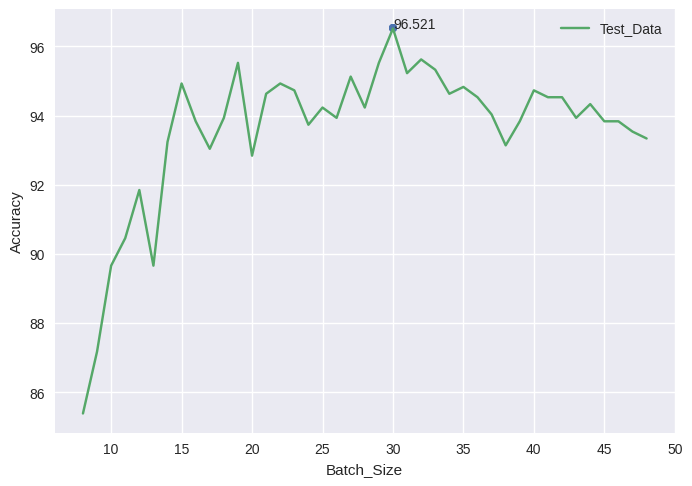

In [23]:
draw_size_acc(dict_bat,custom_path='./tmp',img_title=img_title,suf=dirs)

In [24]:
metrics_scores(test_evl_result,n_classes,cla_dict)

+--------+-----------+--------+--------+----------+
|  Type  | Precision | Recall |   F1   | Accuracy |
+--------+-----------+--------+--------+----------+
| akiec  |    1.0    | 0.9394 | 0.9687 |          |
|  bcc   |   0.8983  |  1.0   | 0.9464 |          |
|  bkl   |   0.9444  | 0.9027 | 0.9231 |          |
|   df   |    0.8    | 0.7273 | 0.7619 |          |
|  mel   |   0.8872  |  1.0   | 0.9402 |          |
|   nv   |   0.9954  | 0.9714 | 0.9832 |          |
|  vasc  |   0.8235  |  1.0   | 0.9032 |          |
| Total: |   0.907   | 0.9344 | 0.9181 |  0.9652  |
+--------+-----------+--------+--------+----------+


In [25]:
metrics_scores(val_evl_result,n_classes,cla_dict)

+--------+-----------+--------+--------+----------+
|  Type  | Precision | Recall |   F1   | Accuracy |
+--------+-----------+--------+--------+----------+
| akiec  |   0.9524  | 0.8696 | 0.9091 |          |
|  bcc   |   0.913   | 0.8077 | 0.8571 |          |
|  bkl   |   0.8182  | 0.9545 | 0.8811 |          |
|   df   |    1.0    |  0.5   | 0.6667 |          |
|  mel   |   0.7778  | 0.6176 | 0.6885 |          |
|   nv   |   0.991   | 0.9955 | 0.9932 |          |
|  vasc  |   0.9091  |  1.0   | 0.9524 |          |
| Total: |   0.9088  | 0.8207 | 0.8497 |  0.9638  |
+--------+-----------+--------+--------+----------+


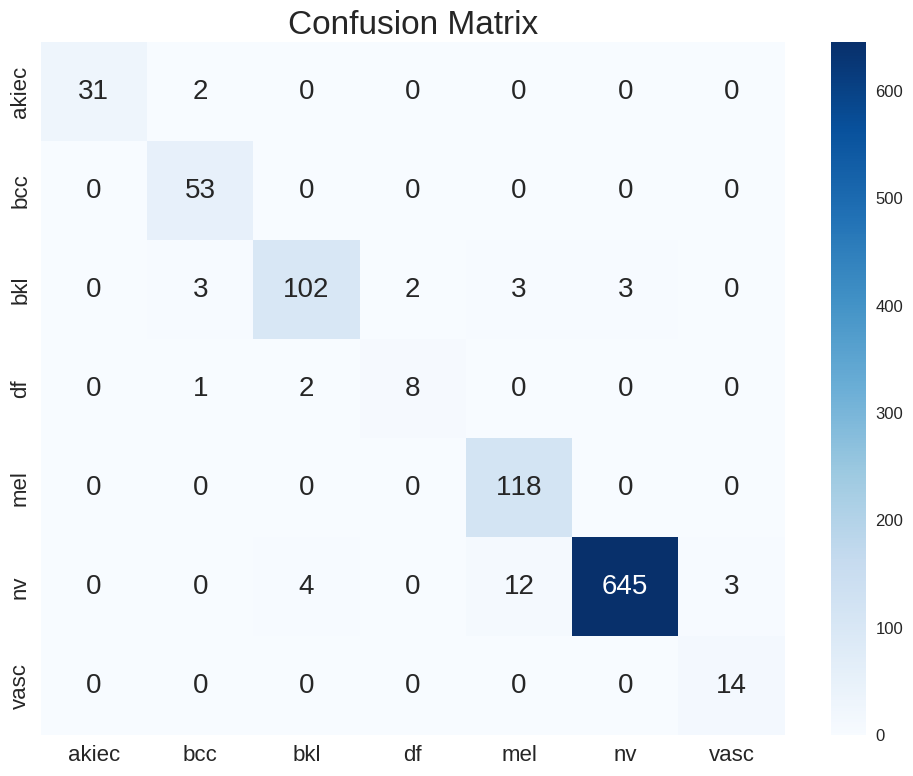

In [26]:
confusion_matrix(test_evl_result,n_classes,cla_dict,test_dataset,img_title=img_title,suf=dirs)

In [27]:
# #save
s0 = np.array(train_acc_list)
np.save(f'./tmp/{img_title}/{dirs}/{img_title}_train_acc_{suf}.npy', s0)
s1 = np.array(train_loss_list)
np.save(f'./tmp/{img_title}/{dirs}/{img_title}_train_loss_{suf}.npy', s1)
s2 = np.array(test_acc_list)
np.save(f'./tmp/{img_title}/{dirs}/{img_title}_test_acc_{suf}.npy', s2)
s3 = np.array(val_acc_list)
np.save(f'./tmp/{img_title}/{dirs}/{img_title}_val_acc_{suf}.npy', s3)
s4 = np.array(dict_batch)
np.save(f'./tmp/{img_title}/{dirs}/{img_title}_dict_batch_{suf}.npy', s4)

In [28]:
torch.cuda.memory.empty_cache()

In [29]:
# show.test(write=False,custom_path='./tmp',img_title=img_title,suf=dirs)